In [ ]:
import pandas as pd
import numpy as np
import cupy as cp

import time
import requests
import datetime 
import logging
logging.getLogger('sqlalchemy.engine').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")

import sys 
sys.path.append('C:/Users/dohyu/Desktop/Github/side_proj_fifa')

import matplotlib.pyplot as plt 
import matplotlib as mpl

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns 
import scipy.stats as stats

import xgboost as xgb

from sqlalchemy import create_engine, text

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from temp_folder.sub_function import fetch_data, db_conn, position_rating, append_match_user_data


: 

In [ ]:
def db_conn(_username, _password, _host, _port, _database) : 
    db_engine = sqlalchemy.engine.URL.create(
        drivername = "mysql+pymysql",
        username = _username,
        password = _password,
        host = _host,
        port = _port,
        database = _database,
    )

    return create_engine(db_engine)

: 

In [ ]:
engine = db_conn('root', 'Dhyoon96!', '127.0.0.1', 3306, 'side_proj_fco')
df_query = 'SELECT * FROM match_user'

# Use the connection to read the SQL query into a DataFrame
with engine.connect() as connection:
    df1 = pd.read_sql(df_query, con = connection)

position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

df2 = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 
                          'match_avg_rating', 'match_total_goal',
                          'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
                          'match_total_shoot', 'match_total_shoot_eff', 
                          'match_total_pass_short_suc', 
                          'match_total_pass_through_suc', 
                          'match_total_pass_long_suc', 
                          'match_total_shoot_outpenalty_suc', 
                          'match_total_shoot_inpenalty_suc']
                          + position_ratings_col)

In [ ]:
df2['match_result'] = df2['match_result'].map({'승': 1, '패': 0})

X = df2.drop('match_result', axis = 1)
y = df2['match_result']

# Train-test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = y)

# Data scaling
scaler = MinMaxScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
X_test_scaled = scaler.transform(X_test)

# Convert data to GPU arrays
X_temp_scaled_gpu = cp.array(X_temp_scaled)
X_test_scaled_gpu = cp.array(X_test_scaled)
y_temp_gpu = cp.array(y_temp)
y_test_gpu = cp.array(y_test)

# XGBoost Classifier with K-fold, GridSearch

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1.0]}

# K-Fold 설정
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Define the model with GPU support
model = xgb.XGBClassifier(
    tree_method = 'gpu_hist',  # Use GPU
    eval_metric = "logloss",
    use_label_encoder = False,  # Disable the deprecated label encoder
    random_state = 42)

# Hyperparameter tuning using Grid Search
grid_search = GridSearchCV(estimator = model, 
                           param_grid = param_grid, 
                           cv = kf, 
                           verbose = 1, 
                           n_jobs = -1)

In [ ]:
grid_search.fit(X_temp_scaled_gpu.get(), y_temp_gpu.get())

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

In [ ]:
# Best model from Grid Search
best_model = grid_search.best_estimator_

# 최종 테스트 데이터 평가
y_test_pred = best_model.predict(X_test_scaled_gpu.get())

print("\nTest Accuracy:", accuracy_score(y_test_gpu.get(), y_test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test_gpu.get(), y_test_pred))

# 피처 중요도 시각화
feature_importance_avg = best_model.feature_importances_
sorted_idx = feature_importance_avg.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx], feature_importance_avg[sorted_idx])
plt.xlabel("Average Feature Importance (XGBoost)")
plt.title("Feature Importance Across K-Folds")

plt.tick_params(axis = 'y', labelsize = 5)  # Set the label size to small for y-axis
plt.tick_params(axis = 'x')  # Set the label size to small for x-axis

for i, v in enumerate(feature_importance_avg[sorted_idx]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

# RandomForest Classifier

In [ ]:
model = RandomForestClassifier(random_state = 42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator = model, 
                           param_grid = param_grid, 
                           cv = kf, 
                           n_jobs = -1, 
                           verbose = 2)

In [ ]:
grid_search.fit(X_temp_scaled, y_temp)

# Best model from Grid Search
best_model = grid_search.best_estimator_

# 최종 테스트 데이터 평가
y_test_pred = best_model.predict(X_test_scaled)

print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred))

In [ ]:
# 피처 중요도 시각화
feature_importance_avg = best_model.feature_importances_
sorted_idx = feature_importance_avg.argsort()

plt.figure(figsize = (10, 8))
plt.barh(X.columns[sorted_idx], feature_importance_avg[sorted_idx])
plt.xlabel("Average Feature Importance (Random Forest)")
plt.title("Feature Importance Across K-Folds")

plt.tick_params(axis = 'y', labelsize = 5)  # Set the label size to small for y-axis
plt.tick_params(axis = 'x')  # Set the label size to small for x-axis

for i, v in enumerate(feature_importance_avg[sorted_idx]):
    plt.text(v + 0.001, i, str(round(v, 2)), color = 'black', va = 'center', fontsize = 'small')

plt.show()

In [16]:
# 실제 값과 예측 값을 데이터프레임으로 저장
test_results = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_test_pred
})

# 결과 확인
print(test_results)  # 상위 10개 데이터 출력

     Actual  Predicted
0         0          0
1         1          1
2         1          1
3         1          1
4         1          1
..      ...        ...
436       0          0
437       0          0
438       1          0
439       1          1
440       0          0

[441 rows x 2 columns]


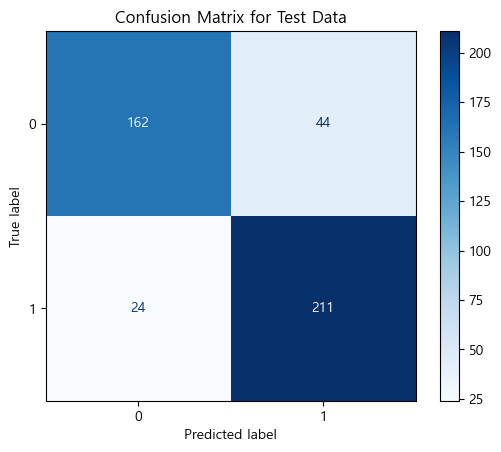

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_test_pred)

# 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Test Data")
plt.show()